# DO ACTION (LDG)

In [ ]:
import time
import timeit
import numpy as np
import random
import sys
sys.path.append('/home/rluser/thesis_ws/src/ROBOT_COMMAND_CODE')

import rtde_receive
import rtde_control 

from robotiq_gripper import RobotiqGripper

robot_ip = "192.168.1.102"
# RTDE communication parameters
rtde_c = rtde_control.RTDEControlInterface(robot_ip)
rtde_r = rtde_receive.RTDEReceiveInterface(robot_ip)
gripper = RobotiqGripper()
gripper.connect(robot_ip, 63352)

#### SIM320 POINTS
from POINTS_A320 import *

# MOVE PARAMETERS
speed = 1.2
accel = 0.8

# GET INPUT FROM TERMINAL
def get_user_input():
    '''
    0 --> Fail PULLING
    1 --> Fail MOVING
    2 --> Fail Releasing
    3 --> Success (overall)
    '''
    user_input = int(input("FAIL 0,1,2 or SUCCESS 3? +++ "))
    
    while user_input not in [0, 1, 2, 3]:
        print("Invalid input. 0,1,2,3")
        user_input = int(input("+++ 0, 1, 2, 3 +++"))
    
    return user_input

####################################################################################
def modify_values(values):
    modified_values = []
    for value in values:
        if value in [2, 4, -4, -8, 25, -25, -30, 30]:  # Example condition
            change = random.randint(-5, 5)
            modified_value = value + change
        else:
            modified_value = value
        modified_values.append(modified_value)
    return modified_values

def LDG_DOWN(dur, GOAL, APPROACH):
    selection_vector = [0, 1, 1, 1, 0, 0]
    dir_pullZ = [0, 0, -35, 0, 0, 0]
    dir_pulldownY = [0, 15, -8, 0, 0, 0]
    dir_finalYZ = [0, 0, 10, 0, 0, 0]
    limits = [0.6, 4, 8, 1, 1, 1]

    modified_dir_pullZ = modify_values(dir_pullZ)
    modified_dir_pulldownY = modify_values(dir_pulldownY)
    modified_dir_finalYZ = modify_values(dir_finalYZ)

    print("Modified dir_pullZ:", modified_dir_pullZ)
    print("Modified dir_pulldownY:", modified_dir_pulldownY)
    print("Modified dir_finalYZ:", modified_dir_finalYZ)

    return do_LDG(dur, selection_vector, dir_pulldownY, dir_pullZ, dir_finalYZ, limits, GOAL, APPROACH)

def LDG_UP(dur, GOAL, APPROACH):
    selection_vector = [0, 1, 1, 1, 0, 0]
    dir_pullZ = [0, 0, -30, 0, 0, 0]
    dir_pulldownY = [0, -15, -8, 0, 0, 0]
    dir_finalYZ = [0, 0, 3, 0, 0, 0]
    limits = [0.6, 10, 8, 1, 1, 1]

    modified_dir_pullZ = modify_values(dir_pullZ)
    modified_dir_pulldownY = modify_values(dir_pulldownY)
    modified_dir_finalYZ = modify_values(dir_finalYZ)

    print("Modified dir_pullZ:", modified_dir_pullZ)
    print("Modified dir_pulldownY:", modified_dir_pulldownY)
    print("Modified dir_finalYZ:", modified_dir_finalYZ)

    return do_LDG(dur, selection_vector, dir_pulldownY, dir_pullZ, dir_finalYZ, limits, GOAL, APPROACH)

def do_LDG(dur, selection_vector, dir_pulldownY, dir_pullZ, dir_finalYZ, limits, GOAL, APPROACH):
    
    # Initialize a list to store the data temporarily
    data_records = []

    # FIRST MOVES 
    rtde_c.moveJ_IK(GOAL, speed, accel)

    # ZEROING FTSENSOR
    rtde_c.zeroFtSensor()
    time.sleep(.1)
    gripper.move_and_wait_for_pos(230, 180, 150)
    time.sleep(.1)
    
    # Record data for a specified duration
    start_time = time.time()
    target_frequency = 500  # Hz
    i = 0

    while i < dur:
        # Start iteration timing
        iteration_start_time = timeit.default_timer()
        t_start = rtde_c.initPeriod()
        
        task_frame = rtde_r.getActualTCPPose()
        if i < 400:
            rtde_c.forceMode(task_frame, selection_vector, dir_pullZ, 2, limits)
        elif i < 2400 and i >= 400:
            rtde_c.forceMode(task_frame, selection_vector, dir_pulldownY, 2, limits)
        else:
            rtde_c.forceMode(task_frame, selection_vector, dir_finalYZ, 2, limits)
        rtde_c.waitPeriod(t_start)

        # Read data
        force_data = rtde_r.getActualTCPForce()
        pose_data = rtde_r.getActualTCPPose()
        q_data = rtde_r.getActualQ()
        timestamp = time.time() - start_time

        # Append data to the list
        data_records.append([
            timestamp, 
            *pose_data, 
            *force_data, 
            q_data[3], q_data[4], q_data[5]
        ])

        # Adjust sleep duration for target frequency
        iteration_time = timeit.default_timer() - iteration_start_time
        sleep_duration = 1.0 / target_frequency - iteration_time
        if sleep_duration > 0:
            time.sleep(sleep_duration)
        i += 1

    # Convert to NumPy array
    data_array = np.array(data_records)

    # Return the array for temporary use
    return data_array

# Temporarily store data without saving to a file
GOAL = [-0.685026, 0.656226, 0.177332, -1.515234, -1.565224, 0.991631]
APPROACH = [-1.304376, -0.787059, 1.275866, 3.738787, -0.491474, -1.046675]

# Example for running LDG_DOWN and storing the result in a variable
ldg_down_data = LDG_DOWN(3000, GOAL, APPROACH)

# Example for running LDG_UP and storing the result in a variable
ldg_up_data = LDG_UP(3000, GOAL, APPROACH)

# You can access and manipulate the NumPy arrays directly
print(ldg_down_data)
print(ldg_up_data)


# PREPROCESS
call the preprocessing functions (this one is for LDG)

In [ ]:
import sys
sys.path.append('/home/rl_sim/thesis_ws/src/ML/UTILITIES')
from PreProcessingFunctions import myfilter, sliding_sum_window, select_index, add_padding, pad_signal_with_noise

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.signal import butter, filtfilt
from scipy.spatial.transform import Rotation as R

target_length = 3000
"""
LDG     -> 3000
FLAP    -> 1800
SPEED   -> 1800
"""

def preprocess_signal(signal, cutoff_freq=30, target_length=target_length, tonorm=2):
    """
    Preprocesses a signal by filtering, padding/truncating, and normalizing.
    """
    filtered_signal = myfilter(signal, cutoff_freq)

    if len(signal) < target_length:
        # Pad the signal with its last value plus some noise
        padding_length = target_length - len(signal)
        last_value = signal.iloc[-1] if isinstance(signal, pd.Series) else signal[-1]
        padded_signal = np.pad(signal, (0, padding_length), mode='constant', constant_values=last_value)
        
        noise_mean = 0
        noise_std = np.std(signal - filtered_signal)
        noise = np.random.normal(noise_mean, noise_std, padding_length)
        padded_signal[-padding_length:] += noise
    elif len(signal) > target_length:
        # Truncate the signal
        padded_signal = signal[-target_length:]
    else:
        # No padding/truncating needed
        padded_signal = signal

    # Apply filtering
    filt_signal = myfilter(padded_signal, cutoff_freq)

    # Normalize the signal
    mean = np.mean(filt_signal)
    if tonorm == 1 and mean != 0:
        normalized_signal = filt_signal / mean  # Mean normalization
    elif tonorm == 2:
        signal_scaler = StandardScaler()
        normalized_signal = signal_scaler.fit_transform(filt_signal.reshape(-1, 1)).flatten()  # Standard scaling
    elif tonorm == 3:
        signal_scaler = MinMaxScaler()
        normalized_signal = signal_scaler.fit_transform(filt_signal.reshape(-1, 1)).flatten()
    else:
        normalized_signal = filt_signal

    return normalized_signal

def transform_force_torque_to_tcp(tcp_pose, force_base):
    """
    Transforms force and torque data from the base frame to the TCP frame.
    """
    rotation_vector = np.array(tcp_pose[3:])
    rotation_matrix = R.from_rotvec(rotation_vector).as_matrix()
    force_base_vector = np.array(force_base[:3])
    torque_base_vector = np.array(force_base[3:])
    force_tcp_vector = np.dot(rotation_matrix.T, force_base_vector)
    torque_tcp_vector = np.dot(rotation_matrix.T, torque_base_vector)
    
    return np.concatenate((force_tcp_vector, torque_tcp_vector))

def preprocess_data(data):
    """
    Processes a DataFrame by transforming and normalizing the force/torque data.
    """
    try:
        # Check if necessary columns are present
        required_columns = ['Force_X', 'Force_Y', 'Force_Z', 'Torque_X', 'Torque_Y', 'Torque_Z', 
                            'Pose_X', 'Pose_Y', 'Pose_Z', 'Pose_Rx', 'Pose_Ry', 'Pose_Rz', 'Y']
        if not all(col in data.columns for col in required_columns):
            print(f"Skipping data: Required columns are missing.")
            return None, None

        # Convert data to NumPy arrays for faster processing
        tcp_pose = data[['Pose_X', 'Pose_Y', 'Pose_Z', 'Pose_Rx', 'Pose_Ry', 'Pose_Rz']].to_numpy()
        forces = data[['Force_X', 'Force_Y', 'Force_Z']].to_numpy()
        torques = data[['Torque_X', 'Torque_Y', 'Torque_Z']].to_numpy()
        y = data['Y'].values[0]

        # Transform forces and torques to the TCP frame before preprocessing
        transformed_signals = []
        for i in range(len(data)):
            transformed_signal = transform_force_torque_to_tcp(tcp_pose[i], np.concatenate((forces[i], torques[i])))
            transformed_signal[2] = -transformed_signal[2]  # Invert the sign of Force_Z_TCP after the transformation
            transformed_signals.append(transformed_signal)
        
        transformed_signals = np.array(transformed_signals)

        # Preprocess each transformed signal
        signals = []
        for col_idx in range(6):  # 6 columns: Force_X, Force_Y, Force_Z, Torque_X, Torque_Y, Torque_Z
            signal = preprocess_signal(transformed_signals[:, col_idx], cutoff_freq=30)
            signals.append(signal)

        # Process the delta poses
        delta_poses = []
        for col in ['Pose_X', 'Pose_Y', 'Pose_Z']:
            delta_pose = np.abs(data[col].iloc[0] - data[col])
            delta_pose = preprocess_signal(delta_pose.to_numpy(), cutoff_freq=15)
            delta_poses.append(delta_pose)

        # Stack the signals along the third axis
        X = np.dstack(signals + delta_poses)

        return X, y
    except Exception as e:
        print(f"Error processing data: {e}")
        return None, None


In [ ]:
# Column indices for easier access to NumPy array
POSE_IDX = slice(1, 7)  # [Pose_X, Pose_Y, Pose_Z, Pose_Rx, Pose_Ry, Pose_Rz]
FORCE_TORQUE_IDX = slice(7, 13)  # [Force_X, Force_Y, Force_Z, Torque_X, Torque_Y, Torque_Z]

def preprocess_numpy_data(data):
    """
    Processes the NumPy array by transforming and normalizing the force/torque data.
    """
    try:
        # Transform force/torque to TCP frame
        transformed_signals = np.array([
            transform_force_torque_to_tcp(data[i, POSE_IDX], data[i, FORCE_TORQUE_IDX]) for i in range(len(data))
        ])

        # Invert the sign of Force_Z_TCP and preprocess each signal
        signals = [preprocess_signal(transformed_signals[:, i], cutoff_freq=30) for i in range(6)]
        signals[2] = -signals[2]  # Invert Force_Z

        # Preprocess delta poses for Pose_X, Pose_Y, Pose_Z
        delta_poses = [preprocess_signal(np.abs(data[0, i] - data[:, i]), cutoff_freq=30) for i in range(1, 4)]

        # Stack all signals and return
        return np.dstack(signals + delta_poses)
    except Exception as e:
        print(f"Error processing data: {e}")
        return None

# Preprocess the NumPy arrays (ldg_down_data and ldg_up_data)
X_down = preprocess_numpy_data(ldg_down_data)
X_up = preprocess_numpy_data(ldg_up_data)

# Output the preprocessed data shapes
print("Preprocessed LDG_DOWN data shape:", X_down.shape)
print("Preprocessed LDG_UP data shape:", X_up.shape)


## The model is:
```
Building Function:
def build_branched_model(input_shape1, input_shape2, input_shape3, input_shape4):
    # First input branch
    input1 = Input(shape=input_shape1, name='input1')
    x1 = Conv1D(filters=64*FILTN, kernel_size=40, strides=10, activation='relu', padding='same', name='conv1d_1_1')(input1)
    x1 = Conv1D(filters=128*FILTN, kernel_size=4, strides=2, activation='relu', name='conv1d_1_2')(x1)
    x1 = GlobalMaxPooling1D(name='gap1d_1_1')(x1)
    x1 = Flatten()(x1)
        # it was GlobalAveragePooling1D
    
    # Second input branch
    input2 = Input(shape=input_shape2, name='input2')
    x2 = Conv1D(filters=64*FILTN, kernel_size=40, strides=10, activation='relu', padding='same', name='conv1d_2_1')(input2)
    x2 = Conv1D(filters=128*FILTN, kernel_size=4, strides=2, activation='relu', name='conv1d_2_2')(x2)
    x2 = GlobalMaxPooling1D(name='gap1d_2_1')(x2)
    x2 = Flatten()(x2)
    
    # Third input branch
    input3 = Input(shape=input_shape3, name='input3')
    x3 = Conv1D(filters=64*FILTN, kernel_size=40, strides=10, activation='relu', padding='same', name='conv1d_3_1')(input3)
    x3 = Conv1D(filters=128*FILTN, kernel_size=4, strides=2, activation='relu', name='conv1d_3_2')(x3)
    x3 = GlobalMaxPooling1D(name='gap1d_3_1')(x3)
    x3 = Flatten()(x3)
    
    # Fourth input branch
    input4 = Input(shape=input_shape4, name='input4')
    x4 = Conv1D(filters=64*FILTN, kernel_size=40, strides=10, activation='relu', padding='same', name='conv1d_4_1')(input4)
    x4 = Conv1D(filters=128*FILTN, kernel_size=4, strides=2, activation='relu', name='conv1d_4_2')(x4)
    x4 = GlobalMaxPooling1D(name='gap1d_4_1')(x4)
    x4 = Flatten()(x4)
    
    # Concatenate the outputs of the four branches
    merged = concatenate([x1, x2, x3, x4], name='concatenate_1')
    
    # Dense layers
    dense = Dense(64, activation='relu', name='dense_1')(merged)
    #dense = Dense(16, activation='relu', name='dense_2')(dense)
    
    # Output layer for 6-class classification
    output = Dense(OUT_N, activation='softmax', name='output')(dense)
    
    model = Model(inputs=[input1, input2, input3, input4], outputs=output)
    return model


Assign and Deploy Variables Function:
def assign_and_deploy_variables(data_dict):
    for key, data in data_dict.items():
        globals()[f"{key}1"] = data[:, :, 0]
        globals()[f"{key}2"] = data[:, :, 1]
        globals()[f"{key}3"] = np.dstack((data[:, :, 2], data[:, :, 4]))
        globals()[f"{key}4"] = np.dstack((data[:, :, 6], data[:, :, 8]))
```

# <span style="color:red">RANDOM DATA JUST FOR EXAMPLE</span>

In [ ]:
import random 
import numpy as np
# Parameters for generating random data
samples = 100  # Number of samples
time_steps = 3000  # Number of timesteps in each sample
features = 9  # Number of features per timestep

# Generate random data for 'down' and 'up' datasets
X_down = np.random.rand(samples, time_steps, features)
X_up = np.random.rand(samples, time_steps, features)

## Save now your preprocessed data and select the signals to use as input for ML models

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Conv1D, GlobalMaxPooling1D, Flatten, Dense, concatenate
from tensorflow.keras.models import Model

# Load the pre-trained Keras model
model_path = '/home/user/ForceDriven_ARTO/ML_models/../path_to_model.keras'
model = load_model(model_path)

# Function to assign variables for the branched model inputs
def assign_and_deploy_variables(data_dict):
    for key, data in data_dict.items():
        globals()[f"{key}1"] = data[:, :, 0]
        globals()[f"{key}2"] = data[:, :, 1]
        globals()[f"{key}3"] = np.dstack((data[:, :, 2], data[:, :, 4]))
        globals()[f"{key}4"] = np.dstack((data[:, :, 6], data[:, :, 8]))

# Assuming X_down and X_up are already preprocessed NumPy arrays
data_dict = {'down': X_down, 'up': X_up}

# Assign the variables for 'down' and 'up' datasets
assign_and_deploy_variables(data_dict)

# Now, you have:
# down1, down2, down3, down4 for the 'down' dataset
# up1, up2, up3, up4 for the 'up' dataset

# You can pass them to the model to make predictions
predictions_down = model.predict([down1, down2, down3, down4])
predictions_up = model.predict([up1, up2, up3, up4])

# Output the predictions
print("Predictions for LDG_DOWN data:", predictions_down)
print("Predictions for LDG_UP data:", predictions_up)


2024-10-18 17:18:14.189132: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-18 17:18:16.294907: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-10-18 17:18:19.129021: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-18 17:18:19.655371: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. 

1/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step

I0000 00:00:1729264702.444484   23888 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Predictions for LDG_DOWN data: [[0.17192113 0.08753799 0.29088113 0.44965968]
 [0.13389646 0.07177811 0.36998376 0.42434165]
 [0.10885969 0.06192286 0.36459687 0.4646205 ]
 [0.10426596 0.04701825 0.2781489  0.57056695]
 [0.14097972 0.05726074 0.2929904  0.5087691 ]
 [0.10946371 0.05355043 0.29494882 0.54203707]
 [0.10979222 0.05101043 0.32314876 0.51604867]
 [0.13917236 0.05609551 0.32845595 0.47627622]
 [0.1106631  0.05775088 0.3151063  0.5164797 ]
 [0.12408213 0.05277229 0.29625526 0.52689034]
 [0.12359611 0.0648151  0.35137415 0.4602146 ]
 [0.15213454 0.04831897 0.26802194 0.53152454]
 [0.12269083 0.06060838 0.33235112 0.4843496 ]
 [0.10890683 0.07214995 0.36392272 0.45502046]
 [0.1276098  0.04891654 0.2854583  0.5380153 ]
 [0.12835468 0.05460033 0.29947832 0.5175666 ]
 [0.15048733 0.07091141 0.35898304 0.41961813]
 [0.13385473 0.06693143 0.32649684 0.47271696]
 [0.12843318 0.07783853 0.38971737 0.40401083]

# GRAD CAM FUNCTIONS

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from typing import List, Union, Optional

def compute_grad_cam(model: Model, inputs: List[np.ndarray], last_layers_names: str, class_idx: int, epsilon: float = 1e-9) -> np.ndarray:
    model = Model(inputs=model.inputs, outputs=[model.get_layer(last_layers_names).output, model.output])
    with tf.GradientTape() as tape:
        output, predictions = model(inputs)
        loss = predictions[:, class_idx]
    grads = tape.gradient(loss, output) #  list or nested structure of Tensors (or IndexedSlices, or None, or CompositeTensor), one for each element in sources.
    
    #reduced_grads == pooled_grads 
    reduced_grads = tf.reduce_mean(grads, axis=(0, 1))
    output = output[0] #otherwise it will remain a tensor, not a 1D 
    
    #make them workable by numpy 
    reduced_grads = reduced_grads.numpy()
    output = output.numpy()

    for i in range(reduced_grads.shape[-1]):
        output[:, i] *= reduced_grads[i]        #obtaining an heatmap
    
    heatmap = np.mean(output, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    if np.max(heatmap) != 0: heatmap /= np.max(heatmap) #to avoid zero division
    return heatmap

def plot_grad_cam(model: Model, 
                  X_tests: List[Union[np.ndarray, np.ndarray]], 
                  sample_idx: int, 
                  y_test: np.ndarray, 
                  conv_layers: List[str],
                  labels: Optional[List[str]] = None) -> None:
    
    # Prepare inputs
    try:
        inputs = [np.expand_dims(X_test[sample_idx], axis=0) for X_test in X_tests]
    except IndexError as e:
        print(f"Error: {e}. Check if sample_idx {sample_idx} is within the range of X_tests.")
        return
    
    # Predict class index and probabilities
    y_pred_prob = model.predict(inputs)
    class_idx = np.argmax(y_pred_prob, axis=1)[0]
    y_pred_label = class_idx if y_pred_prob.shape[1] > 1 else (y_pred_prob[0][0] > 0.5).astype(int)

    # Compute Grad-CAM heatmaps
    heatmaps = [compute_grad_cam(model, inputs, conv_layer, class_idx) for conv_layer in conv_layers]

    # Plot Grad-CAM heatmaps
    plt.figure(figsize=(12, 3 * len(X_tests)))

    if labels is None:
        labels = [f'Branch {i+1}' for i in range(len(X_tests))]

    for i, (X_test, heatmap) in enumerate(zip(X_tests, heatmaps)):
        plt.subplot(len(X_tests), 1, i + 1)
        #plt.title(f'Grad-CAM for {labels[i]} signal')
        plt.title(f'Grad-CAM for {labels[i]}')
        
        if X_test.ndim == 2:  # Single channel input
            plt.plot(X_test[sample_idx])
            plt.imshow(heatmap[np.newaxis, :], aspect="auto", cmap='summer', alpha=0.6,
                       extent=(0, X_test.shape[1], np.min(X_test[sample_idx]), np.max(X_test[sample_idx])))
            plt.ylim(np.min(X_test[sample_idx]) - 0.0 * np.abs(np.min(X_test[sample_idx])), 
                     np.max(X_test[sample_idx]) + 0.0 * np.abs(np.max(X_test[sample_idx])))
            #plt.ylabel('[m]')
            if i == len(X_tests) - 1:  # Only show x-label for the last subplot
                plt.xlabel('Samples [2ms]')
        elif X_test.ndim == 3:  # Multi-channel input
            for channel in range(X_test.shape[-1]):
                plt.plot(X_test[sample_idx, :, channel], label=f'Signal {channel+1}')
            plt.imshow(heatmap[np.newaxis, :], aspect="auto", cmap='summer', alpha=0.6,
                       extent=(0, X_test.shape[1], np.min(X_test[sample_idx]), np.max(X_test[sample_idx])))
            plt.ylim(np.min(X_test[sample_idx]) - 0.0 * np.abs(np.min(X_test[sample_idx])), 
                     np.max(X_test[sample_idx]) + 0.0 * np.abs(np.max(X_test[sample_idx])))
            # if i == len(X_tests) - 1: 
            #     plt.ylabel('[m]')
            # else:
            #     plt.ylabel('[N]')
            if i == len(X_tests) - 1:  # Only show x-label for the last subplot
                plt.xlabel('Samples [2ms]')
            plt.legend()
        
        plt.colorbar()
    
    plt.suptitle(f"Test data number: {sample_idx} --> Yreal: {y_test[sample_idx]}, Ypred: {y_pred_label}")
    plt.tight_layout()
    plt.show()


# Example usage:
# sample_idx = 6  # Change as needed
# X_tests = [X_test1, X_test2, X_test3]
# conv_layers = ['conv1d_1_3', 'conv1d_2_3', 'conv1d_3_3']
# labels = ['Signal 1', 'Signal 2', 'Signal 3']
# plot_grad_cam(model, X_tests, sample_idx, y_test, conv_layers, labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


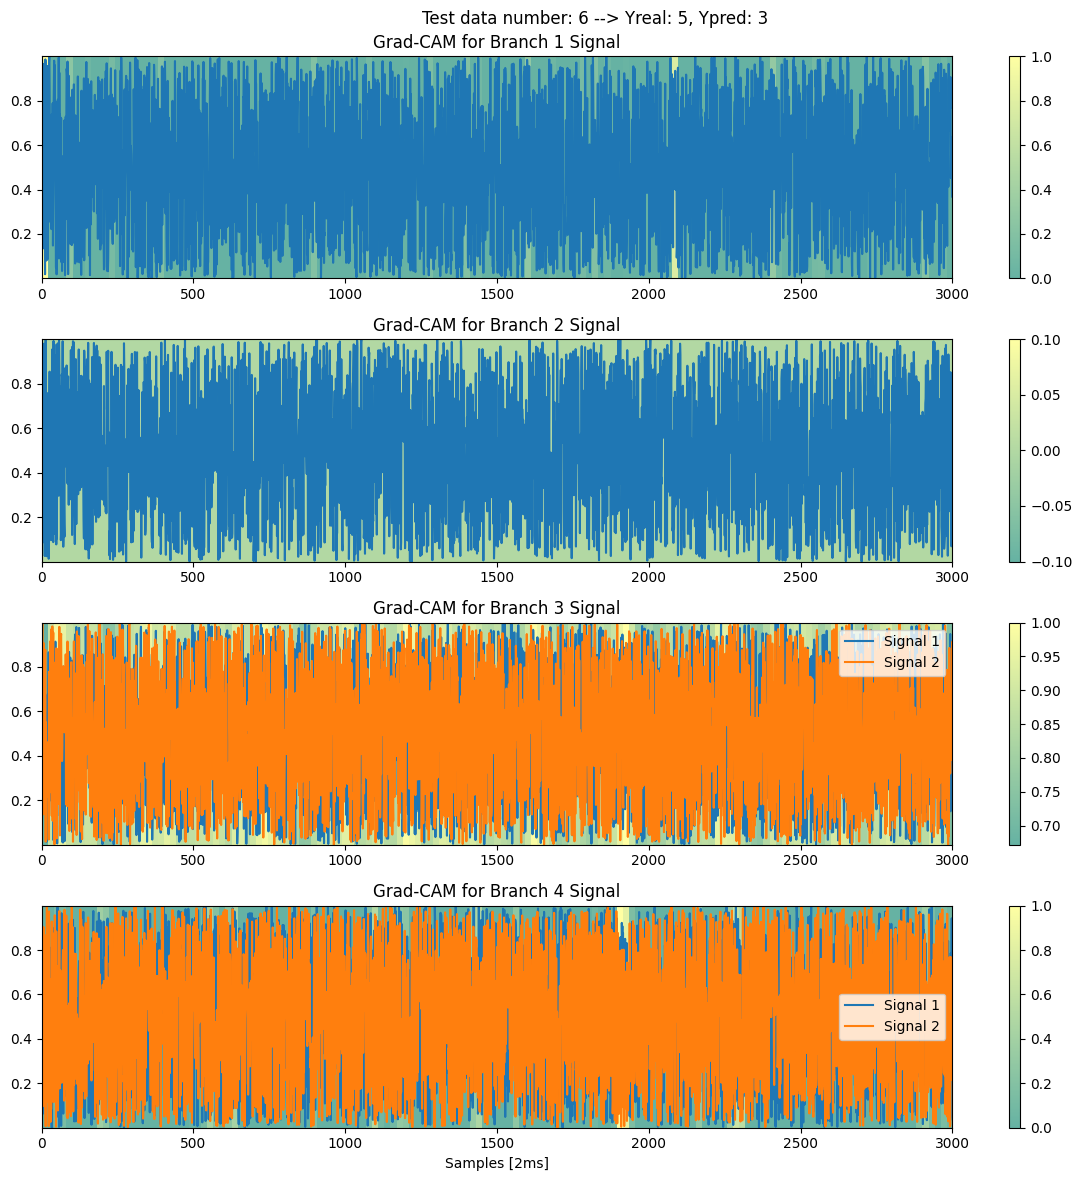

In [5]:
# Assuming the model is already loaded, and you have test data ready
# The conv layers are the names of the last convolutional layers in each branch of the model

sample_idx = 6  # The index of the test sample you want to visualize

# These are the test datasets corresponding to the model's branches
X_tests = [down1, down2, down3, down4]  # Replace with your actual test datasets

# Conv layer names corresponding to the model's branches
conv_layers = ['conv1d_1_2', 'conv1d_2_2', 'conv1d_3_2', 'conv1d_4_2']  # Adjust as per your model

# Ground truth labels for the test set
y_test = np.random.randint(0, 6, size=(X_tests[0].shape[0],))  # Replace this with your actual ground truth labels

# Plot the Grad-CAM heatmap for the given test sample
labels = ['Branch 1 Signal', 'Branch 2 Signal', 'Branch 3 Signal', 'Branch 4 Signal']  # Optional labels
plot_grad_cam(model, X_tests, sample_idx, y_test, conv_layers, labels)
